In [5]:
import numpy as np
import pandas as pd

#NLP Library
import spacy
import re

#Language Detect Library
import pycld2 as cld2

#Feature extraction, model selection and model training library
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#Libraries to check the model performance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Graphing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snb
from wordcloud import WordCloud, STOPWORDS

#Hypothesis Testing
import math
from scipy.stats import chi2_contingency, chisquare, chi2


In [7]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 10.0 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 9.1 MB/s eta 0:00:02
     ----------------- ---------------------- 5.5/12.8 MB 9.3 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 9.4 MB/s eta 0:00:01
     ----------------------------- ---------- 9.4/12.8 MB 9.5 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 8.9 MB/s eta 0:00:01
     ------------------------------------- -- 12.1/12.8 MB 8.7 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 8.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
nlp = spacy.load("en_core_web_sm",disable=["tagger","parser","ner"])

In [9]:
def clean_tweet_text_regex(tweet): 
  
  tweet = tweet.lower() ; 
  
  tweet = re.sub(r"@[A-Za-z0-9]+","", tweet) # we are removing @Mentions from the tweets  
  
  tweet = re.sub(r"#","", tweet) # remove # \ART[\s]+
  
  tweet = re.sub(r"\ART[\s]+","", tweet) # Remove RT in start 
  tweet = re.sub(r"https?:\/\/\S+","", tweet) # Remove hyperlink
  tweet = re.sub("(.)\\1{2,}","\\1", tweet) # Remove more than one characters.
  tweet = re.sub(r"[^A-Za-z0-9\s]+", "",str(tweet)) #remove special characters "!"
  
  
  return tweet


def clean_tweet_spacy_core(doc): 
  tokens = [] ; 
  
  for token in doc: 
    if token.is_stop: # removing the stop words 
      continue ; 
    
    if token.text != token.lemma_:   # root meaning 
      tokens.append(token.lemma_) ; 
    else:
      tokens.append(token.text) ;  
      
  tweet = " ".join(tokens) ; 
  
  return tweet ; 

  
def doc_to_spans(list_of_texts, join_string=' ||| '):
    all_docs = list(nlp.pipe(list_of_texts, batch_size=20, n_process=-1))
    split_inds = [i for i, token in enumerate(all_docs) if token.text == '|||'] + [len(all_docs)]
    new_docs = [all_docs[(i + 1 if i > 0 else i):j] for i, j in zip([0] + split_inds[:-1], split_inds)]
    return new_docs

def get_complete_spans(data,colname):
    splitted_frames = np.array_split(data, 500)
    docs=[]
    i = 1
    for frame in splitted_frames:
        docs.append(doc_to_spans(frame[colname]))
    return docs



def clean_tweet_spacy(data, colname):
    docs = get_complete_spans(data, colname)
    
    print("Tweets cleaning started")
    tweets = []
    
    for doces in docs:
        for doc in doces:
            tweets.append(clean_tweet_spacy_core(doc))

    print("Tweets cleanned")
    return tweets


def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return "not found"
    



In [11]:
labeled_data = pd.read_csv(r"D:\DSC_A2\training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
# D:\DSC_A2\hashtag_joebiden.csv

In [12]:
labeled_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [13]:
labeled_data.columns = ["label", "time", "date", "query", "username", "text"] # we add the columns for the labelled data as its not present in the csv file . 


In [14]:
def check_columns_null_values(data): 
  column_null_values = pd.DataFrame(columns=["column" , "nullvalues"]) ; 
  
  null_values = [] ; 
  
  for column in data.columns:
    sum = data[column].isnull().sum() ; 
    
    print(f"{column}: null percent: {sum/data.shape[0]*100} null values: {sum}/{data.shape[0]} value count: {data.shape[0] - sum}/{data.shape[0]}") ; 
    
    null_values.append(sum) ; 
    
  column_null_values["column"] = data.columns ; 
  column_null_values["nullvalues"] = null_values ;  
  
  return column_null_values ; 

x = check_columns_null_values(labeled_data) ; 


label: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
time: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
date: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
query: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
username: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999
text: null percent: 0.0 null values: 0/1599999 value count: 1599999/1599999


In [15]:
labeled_data["text"] = labeled_data["text"].apply(clean_tweet_text_regex)

train_langs = labeled_data["text"].apply(detect_lang)

print(train_langs);  # most are in english text only . 

0          ENGLISH
1          ENGLISH
2          ENGLISH
3          ENGLISH
4          ENGLISH
            ...   
1599994    ENGLISH
1599995    ENGLISH
1599996    ENGLISH
1599997    ENGLISH
1599998    ENGLISH
Name: text, Length: 1599999, dtype: object


In [17]:
train_langs.value_counts()
labeled_data['Lang'] = train_langs ; 
english_train_data = labeled_data[labeled_data['Lang'] == 'ENGLISH'] ; 

new_train_langs = english_train_data["text"].apply(detect_lang) ; 

print(new_train_langs.value_counts())  ; # now all are english texts only . 

print(len(new_train_langs)) ; 

english_train_data['text'] = clean_tweet_spacy(english_train_data , 'text') ; 

if (np.sum(labeled_data['text'].isnull())) > 0 : 
  labeled_data = labeled_data.dropna(subset=['text']) ; 
  

trump_tweets = pd.read_csv(r"D:\DSC_A2\hashtag_donaldtrump.csv", engine="python")
trump_tweets.head()

text
ENGLISH    1517041
Name: count, dtype: int64
1517041


c:\Users\Avi Sharma\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Avi Sharma\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Tweets cleaning started
Tweets cleanned


C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2580666307.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_train_data['text'] = clean_tweet_spacy(english_train_data , 'text') ;


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529227471237e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.28355589206057e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [18]:
trump_tweets.columns


Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')

In [19]:
columns = ['tweet', 'created_at', 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'user_location', 'lat','long', 'city', 'country', 'continent', 'state', 'state_code']

trump_tweets = trump_tweets[columns] ; 

print(trump_tweets.head()) ;  

                                               tweet           created_at  \
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...  2020-10-15 00:00:01   
1  Usa 2020, Trump contro Facebook e Twitter: cop...  2020-10-15 00:00:01   
2  #Trump: As a student I used to hear for years,...  2020-10-15 00:00:02   
3  2 hours since last tweet from #Trump! Maybe he...  2020-10-15 00:00:02   
4  You get a tie! And you get a tie! #Trump ‘s ra...  2020-10-15 00:00:08   

  likes  retweet_count               user_id user_followers_count  \
0   0.0            0.0           360666534.0               1860.0   
1  26.0            9.0           331617619.0            1067661.0   
2   2.0            1.0             8436472.0               1185.0   
3   0.0            0.0  8.28355589206057e+17                 32.0   
4   4.0            3.0            47413798.0               5393.0   

                  user_location         lat          long        city  \
0  Philadelphia, PA / Miami, FL    25.77427     -

In [20]:
col_null_values = check_columns_null_values(trump_tweets) ; 


tweet: null percent: 0.0014416833919103026 null values: 14/971087 value count: 971073/971087
created_at: null percent: 0.0 null values: 0/971087 value count: 971087/971087
likes: null percent: 0.004325050175730908 null values: 42/971087 value count: 971045/971087
retweet_count: null percent: 0.01585851731101333 null values: 154/971087 value count: 970933/971087
user_id: null percent: 0.016270426851559126 null values: 158/971087 value count: 970929/971087
user_followers_count: null percent: 0.017506155473196533 null values: 170/971087 value count: 970917/971087
user_location: null percent: 30.40479380323287 null values: 295257/971087 value count: 675830/971087
lat: null percent: 54.10277348991388 null values: 525385/971087 value count: 445702/971087
long: null percent: 54.102464557758466 null values: 525382/971087 value count: 445705/971087
city: null percent: 76.60559764470125 null values: 743907/971087 value count: 227180/971087
country: null percent: 54.40861632376913 null values: 52

Text(0.5, 1.0, 'Null Values in Donald Trump Dataset')

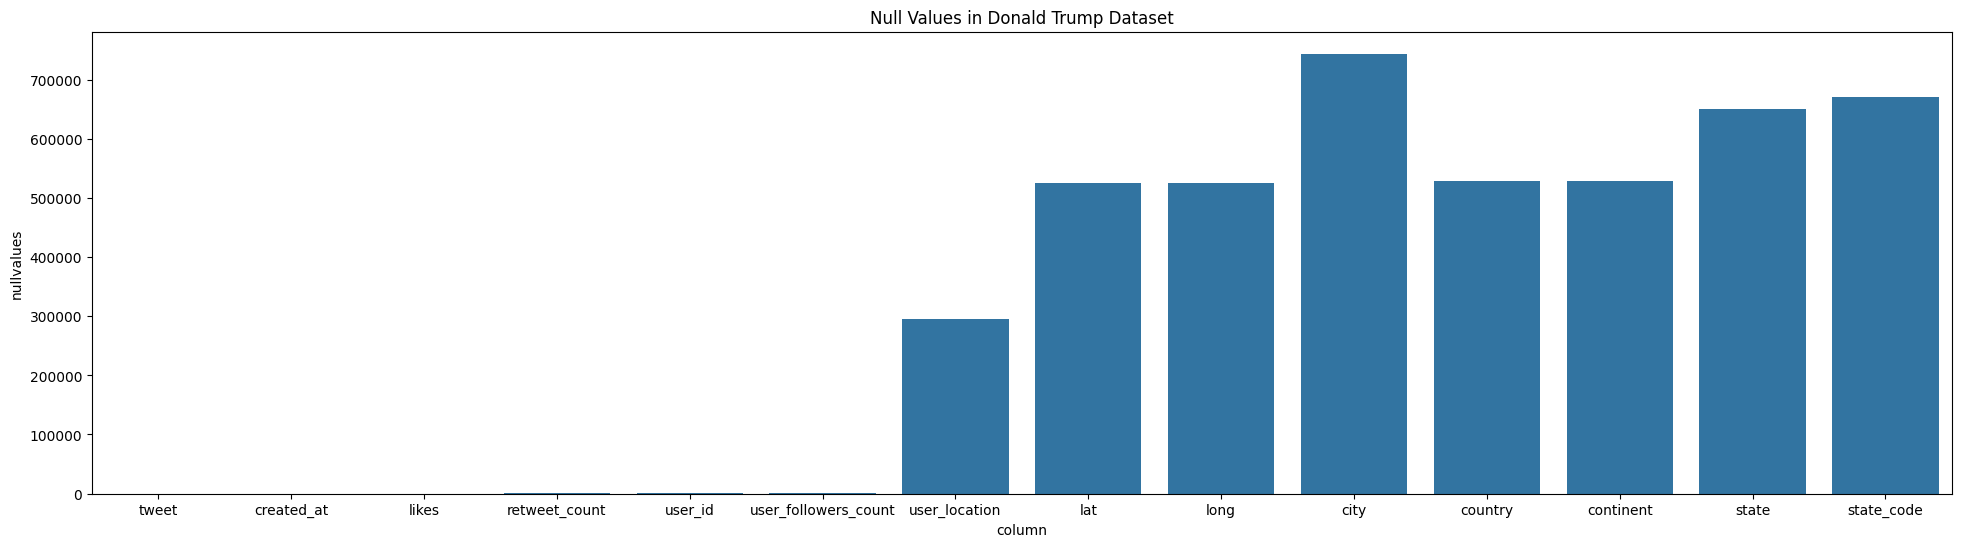

In [21]:
plt.figure(figsize=(24 , 6)) ; 

snb.barplot(x=col_null_values['column'] , y=col_null_values['nullvalues']) ; 

plt.title("Null Values in Donald Trump Dataset")

In [22]:
def clean_data_frame(dataframe): 
  dataframe['likes'] = pd.to_numeric(dataframe['likes'] , errors='coerce') ; 
  
  dataframe['user_followers_count'] = pd.to_numeric(dataframe['user_followers_count'] , errors='coerce') ; 
  
  dataframe['likes'].fillna(dataframe['likes'].mean() , inplace=True) ; 

  dataframe["retweet_count"].fillna(dataframe["retweet_count"].mean(), inplace=True)

  dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors="coerce") 
  
  dataframe["created_at"] = dataframe["created_at"].dt.strftime('%m-%d')
  
clean_data_frame(trump_tweets)


C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2295660147.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['likes'].fillna(dataframe['likes'].mean() , inplace=True) ;
C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2295660147.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [23]:
np.sum(trump_tweets["tweet"].isnull())


np.int64(14)

In [24]:
trump_tweets = trump_tweets.dropna(subset=['tweet'])
check_columns_null_values(trump_tweets) ; 


tweet: null percent: 0.0 null values: 0/971073 value count: 971073/971073
created_at: null percent: 0.015858745943919766 null values: 154/971073 value count: 970919/971073
likes: null percent: 0.0 null values: 0/971073 value count: 971073/971073
retweet_count: null percent: 0.0 null values: 0/971073 value count: 971073/971073
user_id: null percent: 0.014828957246262639 null values: 144/971073 value count: 970929/971073
user_followers_count: null percent: 0.031202597539010973 null values: 303/971073 value count: 970770/971073
user_location: null percent: 30.40379044623834 null values: 295243/971073 value count: 675830/971073
lat: null percent: 54.10211178768228 null values: 525371/971073 value count: 445702/971073
long: null percent: 54.10180285107299 null values: 525368/971073 value count: 445705/971073
city: null percent: 76.60526036662537 null values: 743893/971073 value count: 227180/971073
country: null percent: 54.40795903088645 null values: 528341/971073 value count: 442732/97107

In [25]:
trump_tweets['tweet'] = trump_tweets['tweet'].apply(clean_tweet_text_regex) ;  
trump_langs = trump_tweets["tweet"].apply(detect_lang)
print(trump_langs.value_counts())  ; 

tweet
ENGLISH     673207
Unknown     127332
SPANISH      41265
GERMAN       37115
FRENCH       31466
             ...  
YORUBA           1
IGBO             1
MALAGASY         1
FIJIAN           1
SAMOAN           1
Name: count, Length: 101, dtype: int64


In [26]:
trump_tweets["Lang"] = trump_langs ; 
eng_tweet_trump = trump_tweets[trump_tweets["Lang"] == "ENGLISH"]
eng_tweet_trump["tweet"] = clean_tweet_spacy(eng_tweet_trump, "tweet")

c:\Users\Avi Sharma\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Avi Sharma\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Tweets cleaning started
Tweets cleanned


C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2836438219.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_tweet_trump["tweet"] = clean_tweet_spacy(eng_tweet_trump, "tweet")


In [28]:
joebiden_tweets = pd.read_csv(r"D:\DSC_A2\hashtag_joebiden.csv", engine="python")


joebiden_tweets.head()
joebiden_tweets = joebiden_tweets[columns] ; 
joe_col_null_values = check_columns_null_values(joebiden_tweets ) ; 

tweet: null percent: 0.010037666988815723 null values: 78/777073 value count: 776995/777073
created_at: null percent: 0.0 null values: 0/777073 value count: 777073/777073
likes: null percent: 0.020461398092585896 null values: 159/777073 value count: 776914/777073
retweet_count: null percent: 0.022906470820630753 null values: 178/777073 value count: 776895/777073
user_id: null percent: 0.023678599050539654 null values: 184/777073 value count: 776889/777073
user_followers_count: null percent: 0.024193351203812254 null values: 188/777073 value count: 776885/777073
user_location: null percent: 30.11428784683035 null values: 234010/777073 value count: 543063/777073
lat: null percent: 54.279198994174294 null values: 421789/777073 value count: 355284/777073
long: null percent: 54.279198994174294 null values: 421789/777073 value count: 355284/777073
city: null percent: 75.95219496752557 null values: 590204/777073 value count: 186869/777073
country: null percent: 54.47403268418797 null values: 

Text(0.5, 1.0, 'Null Values in Joe Biden Dataset')

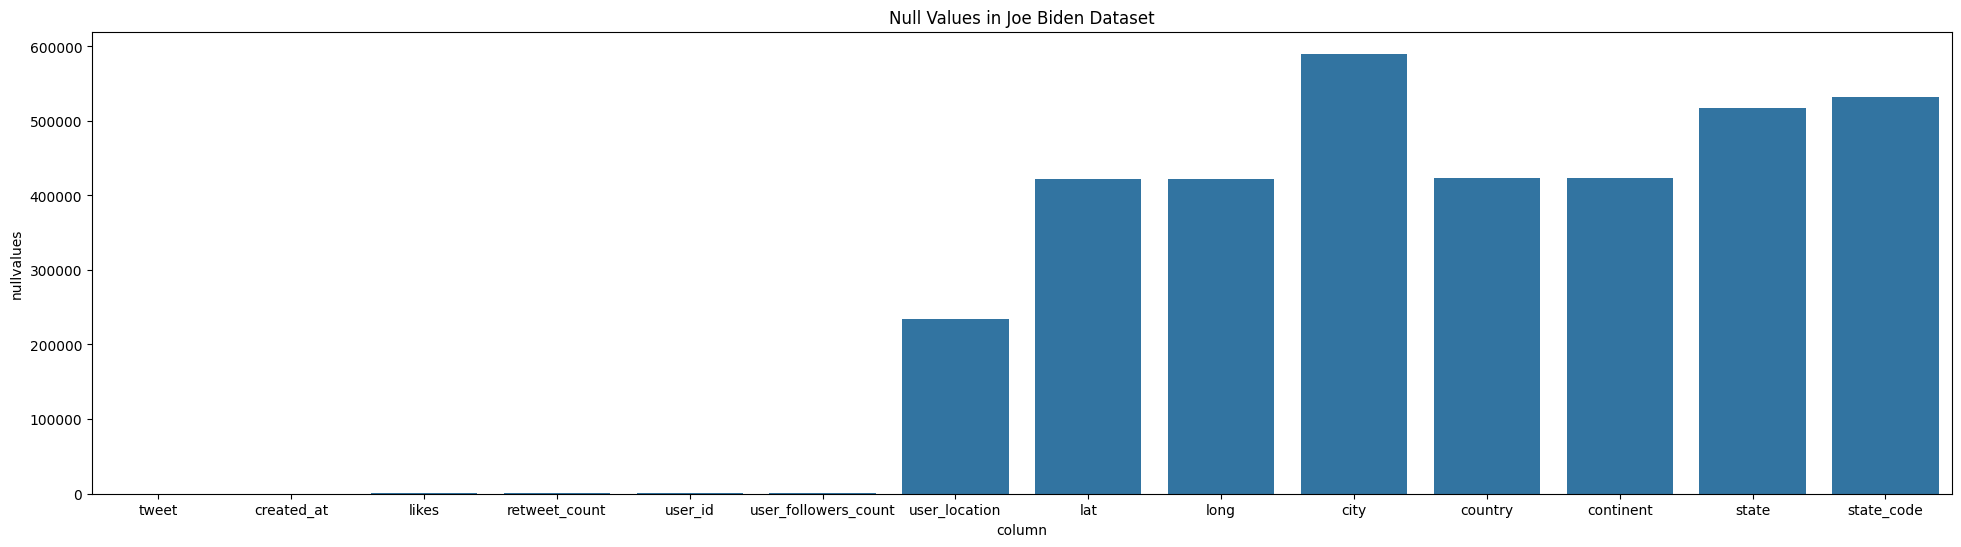

In [29]:
plt.figure(figsize=(24,6))

snb.barplot(x=joe_col_null_values["column"], y=joe_col_null_values["nullvalues"])
plt.title("Null Values in Joe Biden Dataset")

In [30]:
clean_data_frame(joebiden_tweets)


C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2295660147.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['likes'].fillna(dataframe['likes'].mean() , inplace=True) ;
C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2295660147.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [31]:
np.sum(joebiden_tweets["tweet"].isnull())
joebiden_tweets = joebiden_tweets.dropna(subset=['tweet'])
joebiden_tweets["tweet"] = joebiden_tweets["tweet"].apply(clean_tweet_text_regex)
joe_langs = joebiden_tweets["tweet"].apply(detect_lang)
joe_langs.unique()
joe_langs.value_counts()
joebiden_tweets["Lang"] = joe_langs
eng_joebiden_tweets = joebiden_tweets[joebiden_tweets["Lang"] == "ENGLISH"]
eng_joebiden_tweets["tweet"] = clean_tweet_spacy(eng_joebiden_tweets, "tweet")


c:\Users\Avi Sharma\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Avi Sharma\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Tweets cleaning started
Tweets cleanned


C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\4049788329.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_joebiden_tweets["tweet"] = clean_tweet_spacy(eng_joebiden_tweets, "tweet")


In [34]:
def train_model(train_data, targets):
    X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.2)

    model = Pipeline([('vect', HashingVectorizer()),
                      ('logreg', LogisticRegression(max_iter=1000, solver="saga")),
              ])
    model.fit(X_train, Y_train)

    return model, X_test, Y_test

def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

train_data = english_train_data['text']
targets = english_train_data["label"]
model, x_test, y_test = train_model(train_data, targets)
check_model_metrics(model, x_test, y_test) # basic modelling to get the polarity for now , we will do better mobing forward . 

ACCURACY:
77.7448922082074

CONFUSSION MATRIX
[[116197  36461]
 [ 31063 119688]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    152658
           4       0.77      0.79      0.78    150751

    accuracy                           0.78    303409
   macro avg       0.78      0.78      0.78    303409
weighted avg       0.78      0.78      0.78    303409



In [35]:
def get_sentiments(model, data, level_of_signifence):
    sentiments=[]
    polarity = []
    prediction_prob = model.predict_proba(data)

    for prob in prediction_prob:
        dif = prob[1] - prob[0]
        polarity.append(prob[1])
        if dif >= -level_of_signifence and dif <= level_of_signifence:
            sentiments.append("Neutral")
        elif dif > level_of_signifence:
            sentiments.append("Positive")
        else:
            sentiments.append("Negative")
            
    return sentiments, polarity
trump_tweets_data = eng_tweet_trump["tweet"]
trump_sentiments, tump_polarity = get_sentiments(model, trump_tweets_data, 0.1)
joe_tweets_data = eng_joebiden_tweets["tweet"]
joe_sentiments, joe_polarity = get_sentiments(model, joe_tweets_data, 0.1)


In [36]:
pd.Series(trump_sentiments).value_counts(normalize=True)
pd.Series(joe_sentiments).value_counts(normalize=True)
eng_tweet_trump["sentiments"] = trump_sentiments
eng_tweet_trump["polarity"] = tump_polarity

C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2124434170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_tweet_trump["sentiments"] = trump_sentiments
C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\2124434170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_tweet_trump["polarity"] = tump_polarity


In [37]:
eng_joebiden_tweets["sentiments"] = joe_sentiments
eng_joebiden_tweets["polarity"] = joe_polarity

C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\3330981524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_joebiden_tweets["sentiments"] = joe_sentiments
C:\Users\Avi Sharma\AppData\Local\Temp\ipykernel_29608\3330981524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_joebiden_tweets["polarity"] = joe_polarity


In [38]:
all_polarity = pd.concat([eng_tweet_trump["polarity"], eng_joebiden_tweets["polarity"]])

In [39]:
sample = eng_joebiden_tweets["polarity"].sample(n=50)


In [40]:
x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

sample mean:  0.6062237308393723 , population mean:  0.5751577131685005 , sigma:  0.2023053707962758 , n:  50


In [41]:
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)

Z calculated value is:  1.0858333455544105


Z-test for two proportions : Proportion Test on Positive/Negative Sentiments (Sentiment Ratio)

Goal: Compare the proportion of positive sentiments between Biden and Trump tweets to see if there is a significant difference in the positivity rate.

H0 : There is no significant difference in the proportion of positive sentiments in Trump and Biden tweets
H1 : There is significant difference in the proportion of positive sentiments in Trump and Biden tweets

![alt text](image-1.png)

In [63]:
alpha = 0.05
z_tab = 1.96  # 95% confidence level 
biden_pos = eng_joebiden_tweets[eng_joebiden_tweets["sentiments"] == "Positive"].shape[0]
trump_pos = eng_tweet_trump[eng_tweet_trump["sentiments"] == "Positive"].shape[0]
tot_biden = eng_joebiden_tweets.shape[0]
tot_trump = eng_tweet_trump.shape[0]

p1 = biden_pos / tot_biden  
p2 = trump_pos / tot_trump  

P = (p1* tot_biden + p2 * tot_trump) / (tot_biden + tot_trump)

#formula from class slides
z_cal = (p1 - p2) / math.sqrt(P * (1 - P) * (1 / tot_biden + 1 / tot_trump))

print("Z-statistic:", z_cal)

if abs(z_cal) > z_tab:
    print("Reject H0 : There is a significant difference in positive sentiment proportions.")
else:
    print("Fail to reject H0 : No significant difference in positive sentiment proportions.")


Z-statistic: 104.93735135720476
Reject H0 : There is a significant difference in positive sentiment proportions.
